<a href="https://colab.research.google.com/github/gmanojkumar402-max/Manoj-colab-notebooks/blob/main/Polynomial_regression_with_L2_regularization_production_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Best polynomial degree: 3
Validation R² score: 0.7100930795188246
Full dataset metrics: {'R2': 0.781452936453866, 'MSE': 1.13449612500348}


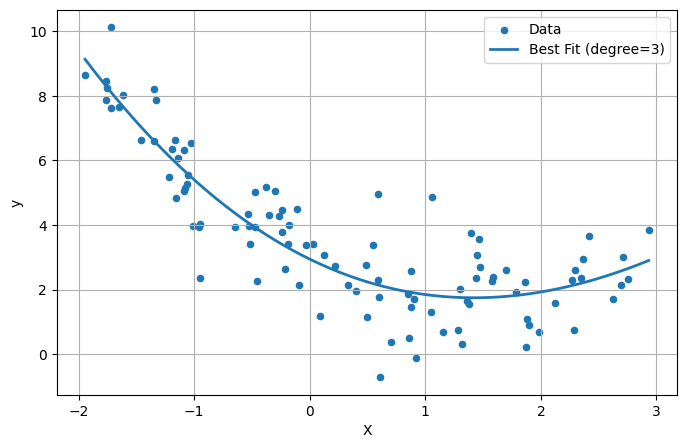

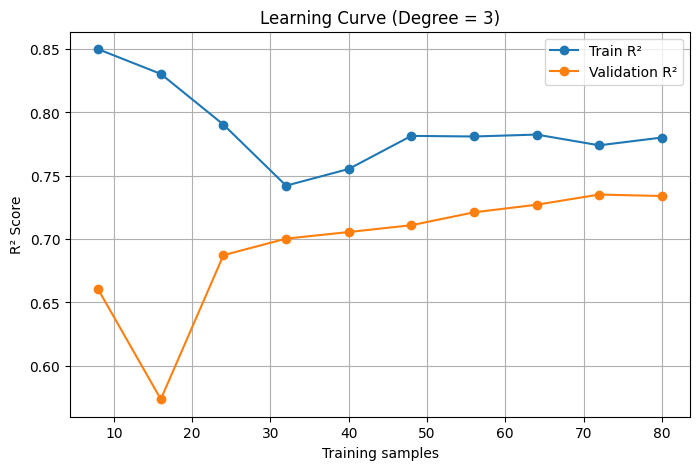

In [1]:

# Production-style Polynomial Regression (Single File)
import numpy as np
from dataclasses import dataclass
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, learning_curve
import matplotlib.pyplot as plt

# Configuration dataclass
@dataclass
class PolynomialRegressionConfig:
    degrees: list = None
    alphas: list = None
    test_size: float = 0.2
    random_state: int = 42

# Main Polynomial Regression Class
class PolynomialRegressionModel:
    def __init__(self, config: PolynomialRegressionConfig):
        self.config = config
        if self.config.degrees is None:
            self.config.degrees = list(range(1, 11))
        if self.config.alphas is None:
            self.config.alphas = np.logspace(-4, 4, 20)
        self.best_degree = None
        self.model = None

    def _build_pipeline(self, degree):
        return Pipeline([
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scale", StandardScaler()),
            ("ridge", RidgeCV(alphas=self.config.alphas, scoring="r2"))
        ])

    def train(self, X, y):
        X = np.array(X).reshape(-1, 1)
        y = np.array(y).ravel()
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.config.test_size, random_state=self.config.random_state
        )
        best_score = -np.inf
        best_model = None
        best_degree = None
        for degree in self.config.degrees:
            pipeline = self._build_pipeline(degree)
            pipeline.fit(X_train, y_train)
            preds = pipeline.predict(X_test)
            score = r2_score(y_test, preds)
            if score > best_score:
                best_score = score
                best_model = pipeline
                best_degree = degree
        self.model = best_model
        self.best_degree = best_degree
        return best_degree, best_score

    def predict(self, X):
        X = np.array(X).reshape(-1, 1)
        return self.model.predict(X)

    def evaluate(self, X, y):
        X = np.array(X).reshape(-1, 1)
        y = np.array(y).ravel()
        preds = self.predict(X)
        return {
            "R2": r2_score(y, preds),
            "MSE": mean_squared_error(y, preds)
        }

    def plot_fit(self, X, y):
        X = np.array(X).reshape(-1, 1)
        y = np.array(y).ravel()
        xx = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
        yy = self.predict(xx)
        plt.figure(figsize=(8, 5))
        plt.scatter(X, y, s=20, label="Data")
        plt.plot(xx, yy, linewidth=2, label=f"Best Fit (degree={self.best_degree})")
        plt.xlabel("X")
        plt.ylabel("y")
        plt.legend()
        plt.grid(True)
        plt.show()

    def plot_learning_curve(self, X, y):
        X = np.array(X).reshape(-1, 1)
        y = np.array(y).ravel()
        train_sizes, train_scores, valid_scores = learning_curve(
            self.model,
            X, y,
            cv=5,
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring="r2",
            shuffle=True,
            random_state=self.config.random_state
        )
        plt.figure(figsize=(8, 5))
        plt.plot(train_sizes, train_scores.mean(axis=1), "o-", label="Train R²")
        plt.plot(train_sizes, valid_scores.mean(axis=1), "o-", label="Validation R²")
        plt.xlabel("Training samples")
        plt.ylabel("R² Score")
        plt.title(f"Learning Curve (Degree = {self.best_degree})")
        plt.grid(True)
        plt.legend()
        plt.show()


# Demo / Execution
if __name__ == "__main__":
    # Generate sample nonlinear data
    m = 100
    X = 5 * np.random.rand(m) - 2
    y = 0.7 * X**2 - 2*X + 3 + np.random.randn(m)

    # Configure model
    config = PolynomialRegressionConfig(
        degrees=range(1, 15),               # Try degrees 1 to 14
        alphas=np.logspace(-3, 3, 15)       # Ridge alphas from 1e-3 to 1e3
    )

    # Create model
    model = PolynomialRegressionModel(config)

    # Train model and select best degree
    best_degree, score = model.train(X, y)
    print("Best polynomial degree:", best_degree)
    print("Validation R² score:", score)

    # Evaluate model on full data
    metrics = model.evaluate(X, y)
    print("Full dataset metrics:", metrics)

    # Plot best-fit curve
    model.plot_fit(X, y)

    # Plot learning curve
    model.plot_learning_curve(X, y)
